# Ground state enegry

* Molecule : $BeH_2$
* Bond length : 1.33 Angstroms
* Circuit knitting - Entanglement forging technique to reduce number of qubits

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal, RealAmplitudes

from qiskit_ibm_runtime import QiskitRuntimeService, Options

import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

import matplotlib.pyplot as plt


from typing import Union, List
from qiskit import QuantumCircuit, execute, IBMQ, Aer, assemble
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options, Estimator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import *
import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms.minimum_eigensolvers import VQE


# BeH2 molecule

In [2]:
molecule = Molecule(
geometry=[
        ("H", [0.0, 0.0, -1.33]),
        ("Be", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 1.33]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")
problem = ElectronicStructureProblem(driver1)

In [ ]:
ansatz = EntanglementForgingAnsatz(
    circuit_u=RealAmplitudes(7, entanglement="linear",reps=1,parameter_prefix="y",insert_barriers=True),
    bitstrings_u=[(1, 0, 1, 0, 1, 0,0), (0, 1,0,1,1,0,0)],
)

#ansatz1.circuit_u.draw()

In [ ]:
#ansatz1.circuit_u.decompose().draw()

## VQE_EntanglementForging

In [6]:
# We have created here class called CircuitExecutor. Which will take input 1. Backend 2. Service 3. Hamiltonian
#4. ansatz, optimizer, initial point from the user. 4. will be different for every molecule
# By default the res_level = 1 i.e. M3 if you want to have ZNE(PEC) just put res_level = 2(3)
# By default opt_level = 3, you can change it accordingly, 3 is highest level optimization
# see the example below!


class CircuitExecutor:
    def __init__(self, back, service, problem, ansatz, optimizer, initial_point, observable = None, error_mit = True, res_level = 2, opt_level = 3, noise_model = None, shots = 1024):
        """
        Initialize a CircuitExecutor object.
        Args:
            service (QiskitRuntimeService): The Qiskit runtime service to use.
            error_mit (bool, optional): A flag indicating whether to use error mitigation when running the circuit.
                                        Defaults to True.
            noise_model: User have to give their own noise_model, Default is None. 
            back: user have to give the backend name as a string
            res_level: Resilience level 1 means M3, If user want to use ZNE or PEC he has to provide res_level=2 for ZNE and 3 for PEC                   opt_level: Optimization Level 3, user can change it from 0 to 3               
        """
        self.service = service
        self.backend = back
        self.error_mit = error_mit
        self.shots = shots
        self.noise_model = noise_model
        self.res_level = res_level
        self.opt_level = opt_level
        self.observable = observable
        self.problem = problem
        self.ansatz = ansatz
        self.optimizer=optimizer
        self.initial_point = initial_point
        self.result = []

    def execute(self, back):

        """
        Execute a quantum circuit.
        Args:
            circuits (QuantumCircuit or a list of circuits): The quantum circuit/s to execute.
        Returns:
            Result: The result of executing the circuit.
        """
        options_with_em = Options(
            simulator={
                "noise_model": self.noise_model,
                "seed_simulator": 42,
            }, resilience_level = self.res_level, optimization_level = self.opt_level )
        options= [Options(execution={"shots": 1000}, optimization_level = self.opt_level, resilience_level = self.res_level), 
                  Options(execution={"shots": 2000}, optimization_level = self.opt_level, resilience_level = self.res_level)]
        backend = self.backend  # ask for a backend
        if self.error_mit:
            f = open("mit_res.txt","w")
            with Session(service = self.service, backend=backend, max_time='3h') as session:
                if back[0] =="ibmq_qasm_simulator":
                    if self.noise_model == None:
                        raise ValueError("Please Give suitable noise model. You have not selected any noise model with qasm simulator")
                    else:
                        opt = options_with_em
                else:
                    opt = options
                
                solver = EntanglementForgingGroundStateSolver(
                    ansatz=self.ansatz,
                    optimizer=self.optimizer,
                    service=self.service,
                    backend_names=self.backend,
                    options=options,
                    initial_point=self.initial_point,
                )
                result = solver.solve(self.problem)
                
                return result

In [7]:
optimizer = COBYLA(maxiter=200)
np.random.seed(6)
initial_point = np.random.random(ansatz.circuit_u.num_parameters)

#QiskitRuntimeService.save_account(channel='ibm-quantum', token="YOUR_TOKEN", overwrite=True)
#service = QiskitRuntimeService(
#    channel = "ibm_quantum",
#    instance = "qhack-event/main/level-1,")

service = None
backend_names = ["ibmq_qasm_simulator"] * 2 

# Import FakeBackend
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)


In [38]:
executor = CircuitExecutor(backend_names, service, problem, ansatz, optimizer, res_level = 3, opt_level = 3, initial_point=initial_point, error_mit = True, noise_model = noise_model)

results = executor.execute(backend_names)

In [39]:
# electronic ground state energy

results.groundenergy

-18.9291551336193

In [40]:
# total ground state energy (electronic+nuclear)

results.groundenergy + results.energy_shift

-15.547195514957645

Energy:


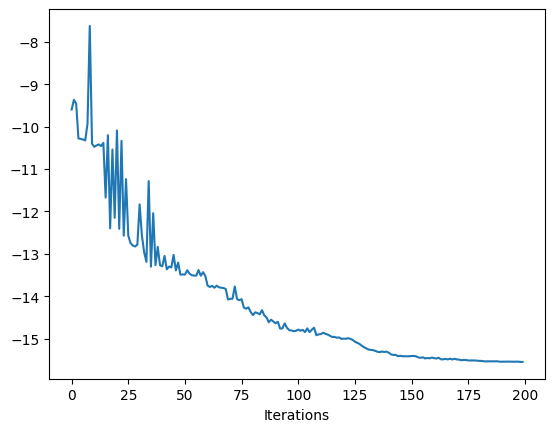

Schmidt Coefficients:


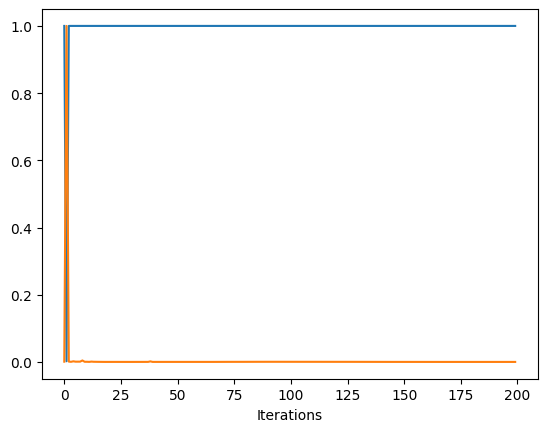

Parameters:


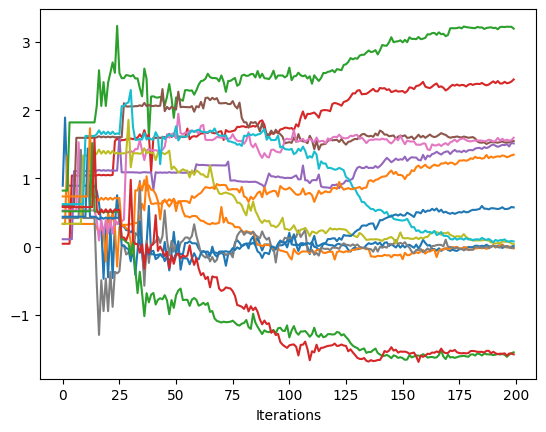

In [42]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue+results.energy_shift for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
#plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [43]:
# runtime in seconds
results.elapsed_time

791.6411955356598

## Exact eigenenergy

In [44]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolver()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [45]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.second_q.drivers import PySCFDriver as pyscfDriver_


driver_ = pyscfDriver_(
        atom ="H 0.0, 0.0, -1.33; Be 0.0, 0.0, 0.0; H 0.0, 0.0, 1.33",
    charge=0,
    basis = "sto3g")
problem_ = driver_.run()
second_q_ops = problem_.second_q_ops()
mapper = ParityMapper()
converter = QubitConverter(ParityMapper())
print(exact_solver(problem_, converter))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.977077181235
  - computed part:      -18.977077181235
~ Nuclear repulsion energy (Hartree): 3.381959618662
> Total ground state energy (Hartree): -15.595117562573
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


## Result

VQE_Entanglement forging = -15.547195514957645 Hatree

Exact_NumpySolver = -15.595117562573 Hatree